In [1]:
import pandas as pd
import numpy as np

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [60]:
# Configurar el controlador de Chrome
driver = webdriver.Chrome()

# Abrir la página web
driver.get("https://systems.inei.gob.pe/SIRTOD/app/consulta")

# Esperar a que la página cargue completamente
wait = WebDriverWait(driver, 25)

# Paso 1: Esperar a que el loader desaparezca
wait.until(EC.invisibility_of_element_located((By.ID, "loader")))

# Paso 2: Hacer clic en el campo "Buscar indicador"
search_field = wait.until(EC.visibility_of_element_located((By.XPATH, '//*[@id="indicador-cajatexto"]')))
ActionChains(driver).move_to_element(search_field).perform()
search_field.click()

# Paso 3: Escribir "anemia" en el campo de búsqueda
search_field.send_keys("anemia")
search_field.send_keys(Keys.RETURN)

# Paso 4: Hacer clic en los checkboxes correspondientes
checkboxes = [
    '//*[@id="nodoh17779"]/img',
    '//*[@id="nodoh17780"]/img',
    '//*[@id="nodoh17781"]/img',
    '//*[@id="nodoh17782"]/img'
]

for checkbox_xpath in checkboxes:
    checkbox = wait.until(EC.element_to_be_clickable((By.XPATH, checkbox_xpath)))
    checkbox.click()

# Paso 5: Hacer clic en el botón de "Ejecutar"
ejecutar_button = wait.until(EC.element_to_be_clickable((By.XPATH, '//*[@id="ubigeo-ejecutar"]/button')))
ejecutar_button.click()

# Paso 6: Extraer la tabla que aparece después de aplicar los filtros
table = wait.until(EC.presence_of_element_located((By.CLASS_NAME, "pvtTable")))
rows = table.find_elements(By.TAG_NAME, "tr")

# Crear una lista para almacenar los datos
data = [[cell.text for cell in row.find_elements(By.TAG_NAME, "td")] for row in rows if row.find_elements(By.TAG_NAME, "td")]

# Convertir los datos en un DataFrame de pandas y eliminar la última columna vacía
df = pd.DataFrame(data).iloc[:, :-1]

# Definir los encabezados manualmente (para las 18 columnas restantes)
headers = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Verificar que el número de columnas coincida con los encabezados
if df.shape[1] == len(headers):
    df.columns = headers
else:
    print("El número de columnas en el DataFrame no coincide con la cantidad de encabezados proporcionados.")

# Agregar las dos nuevas columnas al lado izquierdo
df.insert(0, 'Departamento', '')
df.insert(1, 'Indicador Anemia %', '')

# Lista de departamentos
departamentos = [
    "AMAZONAS", "ÁNCASH", "APURÍMAC", "AREQUIPA", "AYACUCHO", "CAJAMARCA", 
    "CALLAO", "CUSCO", "HUANCAVELICA", "HUÁNUCO", "ICA", "JUNÍN", 
    "LA LIBERTAD", "LAMBAYEQUE", "LIMA", "LORETO", "MADRE DE DIOS", "MOQUEGUA", 
    "PASCO", "PIURA", "PUNO", "SAN MARTÍN", "TACNA", "TUMBES", 
    "UCAYALI", "LIMA METROPOLITANA 1/", "LIMA 2/"
]

# Asignar nombres de departamentos
row_idx = 0
for departamento in departamentos:
    if departamento == "LIMA METROPOLITANA 1/":
        # Excepción para "LIMA METROPOLITANA 1/"
        df.loc[row_idx:row_idx+2, 'Departamento'] = departamento
        row_idx += 3
    else:
        df.loc[row_idx:row_idx+3, 'Departamento'] = departamento
        row_idx += 4

# Llenar la columna 'Indicador Anemia %' con el patrón, omitiendo "Severa" para Lima Metropolitana
indicadores = ["Leve", "Moderada", "Severa", "Total"]
indicator_idx = 0

for idx in range(df.shape[0]):
    if df.at[idx, 'Departamento'] == "LIMA METROPOLITANA 1/" and indicator_idx == 2:
        # Saltar "Severa" para Lima Metropolitana
        indicator_idx += 1
    df.at[idx, 'Indicador Anemia %'] = indicadores[indicator_idx]
    indicator_idx = (indicator_idx + 1) % 4  # Reiniciar el patrón cada 4 indicadores

# Eliminar filas adicionales innecesarias
df.drop(index=df.index[[107, 108]], inplace=True)

# Reemplazar los NaN con el promedio de los valores numéricos en la misma fila
for col in df.columns[2:]:  
    df[col] = df[col].astype(str).replace('-', np.nan).str.replace(',', '.')
    df[col] = pd.to_numeric(df[col], errors='coerce') 

df.iloc[:, 2:] = df.iloc[:, 2:].apply(
    lambda row: row.fillna(row.mean()), axis=1
)

# (Opcional) Volver a formatear los números con comas como separador decimal
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: f"{x:.1f}".replace('.', ','))

# Lista de las columnas de los años (como está en tu código)
year_columns = [2000, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

# Convertir los valores a float correctamente, reemplazando comas por puntos
for year in year_columns:
    df[year] = df[year].str.replace(',', '.').astype(float)

# Iterar sobre los departamentos
for depto in df['Departamento'].unique():
    # Filtrar las filas correspondientes a 'Leve', 'Moderada', 'Severa' para este departamento
    rows_to_sum = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'].isin(['Leve', 'Moderada', 'Severa']))]

    # Filtrar la fila correspondiente a 'Total' para este departamento
    total_row_idx = df[(df['Departamento'] == depto) & (df['Indicador Anemia %'] == 'Total')].index

    if not rows_to_sum.empty and not total_row_idx.empty:
        # Iterar sobre las columnas de los años
        for year in year_columns:
            # Sumar los valores de los indicadores 'Leve', 'Moderada', 'Severa' para el año en cuestión
            total_value = rows_to_sum[year].sum(skipna=True)
            
            # Asignar la suma total al año correspondiente en la fila 'Total'
            df.at[total_row_idx[0], year] = total_value

# Ver el DataFrame resultante con los totales actualizados
print(df)
# Cerrar el navegador

              Departamento Indicador Anemia %  2000  2008  2009  2010  2011  \
0                 AMAZONAS               Leve  21.9  23.0  25.3  24.7  21.4   
1                 AMAZONAS           Moderada  20.0  13.7  12.4  14.6   8.2   
2                 AMAZONAS             Severa   0.5   0.4   1.0   1.0   0.5   
3                 AMAZONAS              Total  42.4  37.1  38.7  40.3  30.1   
4                   ÁNCASH               Leve  21.0  22.8  24.4  24.2  17.3   
..                     ...                ...   ...   ...   ...   ...   ...   
102  LIMA METROPOLITANA 1/              Total  24.2  24.2  24.2  24.2  24.2   
103                LIMA 2/               Leve  21.2  21.2  21.2  21.2  21.2   
104                LIMA 2/           Moderada   7.8   7.8   7.8   7.8   7.8   
105                LIMA 2/             Severa   0.2   0.2   0.2   0.2   0.2   
106                LIMA 2/              Total  29.2  29.2  29.2  29.2  29.2   

     2012  2013  2014  2015  2016  2017  2018  2019

# Selección del departamento a evaluar

In [72]:
# Lista de años disponibles
def listar_opciones(df):
    # Extraer los años como columnas numéricas
    anios_disponibles = ['2000'] + [str(year) for year in range(2008, 2023 + 1)]
    
    # Extraer los departamentos únicos
    departamentos_disponibles = df['Departamento'].unique()
    
    print("Años disponibles para el análisis:")
    print(anios_disponibles)
    print("\nDepartamentos disponibles para el análisis:")
    print(departamentos_disponibles)

# Ejecutar la función
listar_opciones(df)

Años disponibles para el análisis:
['2000', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

Departamentos disponibles para el análisis:
['AMAZONAS' 'ÁNCASH' 'APURÍMAC' 'AREQUIPA' 'AYACUCHO' 'CAJAMARCA' 'CALLAO'
 'CUSCO' 'HUANCAVELICA' 'HUÁNUCO' 'ICA' 'JUNÍN' 'LA LIBERTAD' 'LAMBAYEQUE'
 'LIMA' 'LORETO' 'MADRE DE DIOS' 'MOQUEGUA' 'PASCO' 'PIURA' 'PUNO'
 'SAN MARTÍN' 'TACNA' 'TUMBES' 'UCAYALI' 'LIMA METROPOLITANA 1/' 'LIMA 2/']


In [115]:
import pandas as pd

# Leer el archivo CSV
df = pd.read_csv('anemia_data.csv')

# Filtrar el DataFrame para valores "Total"
df_total = df[df['Indicador Anemia %'] == 'Total']

# Normalizar los nombres de los departamentos (primera letra mayúscula)
lista_dptos = df_total['Departamento'].str.title()

# Solicitar al usuario que seleccione un departamento
departamentos_disponibles = lista_dptos.unique()
print("Departamentos disponibles:")
for idx, dept in enumerate(departamentos_disponibles):
    print(f"{idx + 1}. {dept}")

# Pedir al usuario seleccionar el número del departamento
seleccion = int(input("Seleccione el número del departamento que desea visualizar: ")) - 1

# Validar la selección
if 0 <= seleccion < len(departamentos_disponibles):
    departamento_seleccionado = departamentos_disponibles[seleccion]
    print(f'Departamento seleccionado: {departamento_seleccionado}')

else:
    print("Selección no válida. Intente nuevamente.")


Departamentos disponibles:
1. Amazonas
2. Áncash
3. Apurímac
4. Arequipa
5. Ayacucho
6. Cajamarca
7. Callao
8. Cusco
9. Huancavelica
10. Huánuco
11. Ica
12. Junín
13. La Libertad
14. Lambayeque
15. Lima
16. Loreto
17. Madre De Dios
18. Moquegua
19. Pasco
20. Piura
21. Puno
22. San Martín
23. Tacna
24. Tumbes
25. Ucayali
26. Lima Metropolitana 1/
27. Lima 2/


Seleccione el número del departamento que desea visualizar:  1


Departamento seleccionado: Amazonas


In [75]:
# Solicitar al usuario que seleccione un año específico
anios_disponibles = ['2000'] + [str(year) for year in range(2008, 2023 + 1)]
print("Años disponibles:", anios_disponibles)
anio_seleccionado = input("Seleccione el año que desea visualizar: ")

Años disponibles: ['2000', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


Seleccione el año que desea visualizar:  2009


In [101]:
# Solicitar al usuario que seleccione un indicador
indicadores_disponibles = df['Indicador Anemia %'].unique()
print("Indicadores disponibles:")
for idx, ind in enumerate(indicadores_disponibles):
    print(f"{idx + 1}. {ind}")
    
seleccion_indicador = int(input("Seleccione el número del indicador que desea visualizar: ")) - 1
indicador_seleccionado = indicadores_disponibles[seleccion_indicador]

Indicadores disponibles:
1. Leve
2. Moderada
3. Severa
4. Total


Seleccione el número del indicador que desea visualizar:  1


## **Proporción de Anemia por Nivel y Departamento en el Año Seleccionado**

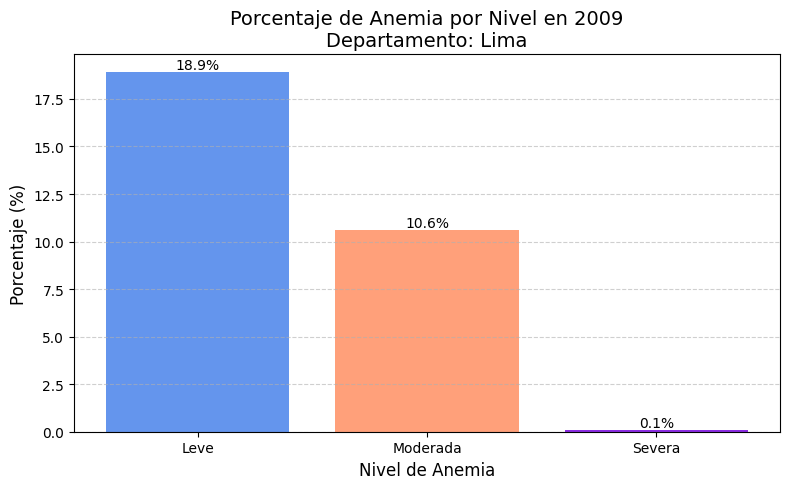

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para generar el gráfico
def generar_grafico(anio, departamento):
    # Filtrar datos por año y departamento
    df_anio = df[['Departamento', 'Indicador Anemia %', anio]]
    df_filtrado = df_anio[df_anio['Departamento'].str.upper() == departamento.upper()]
    
    # Excluir la categoría 'Total'
    df_filtrado = df_filtrado[df_filtrado['Indicador Anemia %'] != 'Total']
    
    # Renombrar las columnas para claridad
    df_filtrado.columns = ['Departamento', 'Indicador', 'Proporción']
    
    # Crear el gráfico
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df_filtrado['Indicador'], df_filtrado['Proporción'], color=['#6495ED', '#FFA07A', '#8A2BE2'])
    
    # Agregar etiquetas encima de las barras
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{bar.get_height():.1f}%", 
                 ha='center', va='bottom', fontsize=10)
    
    # Personalizar el gráfico
    plt.title(f'Porcentaje de Anemia por Nivel en {anio}\nDepartamento: {departamento}', fontsize=14)
    plt.xlabel('Nivel de Anemia', fontsize=12)
    plt.ylabel('Porcentaje (%)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

# Ejemplo de uso
generar_grafico(anio_seleccionado, departamento_seleccionado)

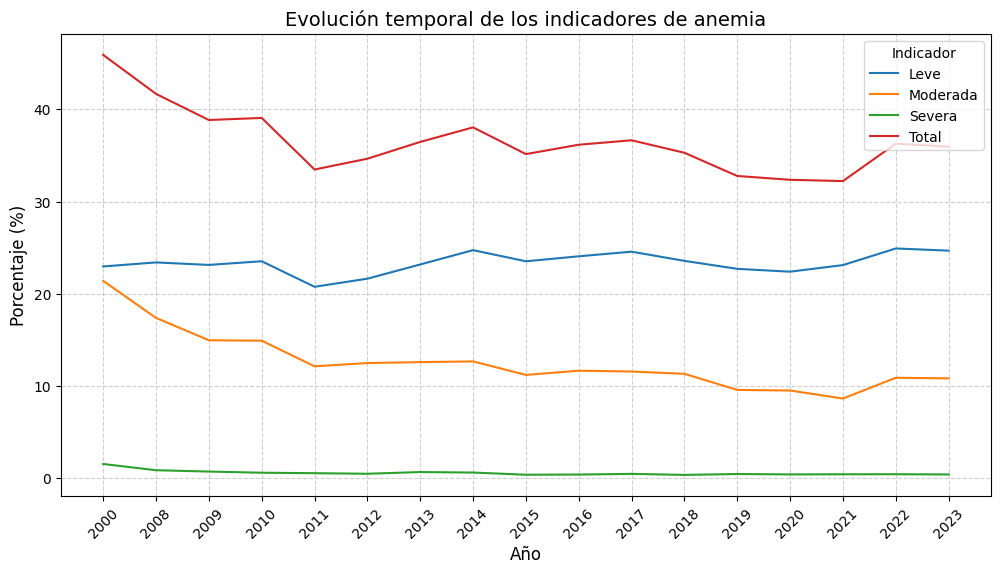

In [119]:
import matplotlib.pyplot as plt

# Filtrar datos relevantes (sin columnas categóricas para el análisis numérico)
numeric_data = df.iloc[:, 2:]

# Calcular estimadores estadísticos
descriptive_stats = numeric_data.describe().T  # Transponer para claridad
descriptive_stats["Range"] = descriptive_stats["max"] - descriptive_stats["min"]
descriptive_stats

# Gráficos: Evolución temporal de los indicadores de anemia
plt.figure(figsize=(12, 6))
for indicator in df["Indicador Anemia %"].unique():
    subset = df[df["Indicador Anemia %"] == indicator]
    mean_values = subset.iloc[:, 2:].mean()
    plt.plot(mean_values.index, mean_values.values, label=indicator)

# Personalización del gráfico
plt.title("Evolución temporal de los indicadores de anemia", fontsize=14)
plt.xlabel("Año", fontsize=12)
plt.ylabel("Porcentaje (%)", fontsize=12)
plt.legend(title="Indicador", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(rotation=45)
plt.show()

# Departamentos con alta prevalencia en 2023 son consistentemente los más afectados en casos de Anemia

### Comparación en el año 2023 de los 5 departamentos con mayor proporción de Anemia

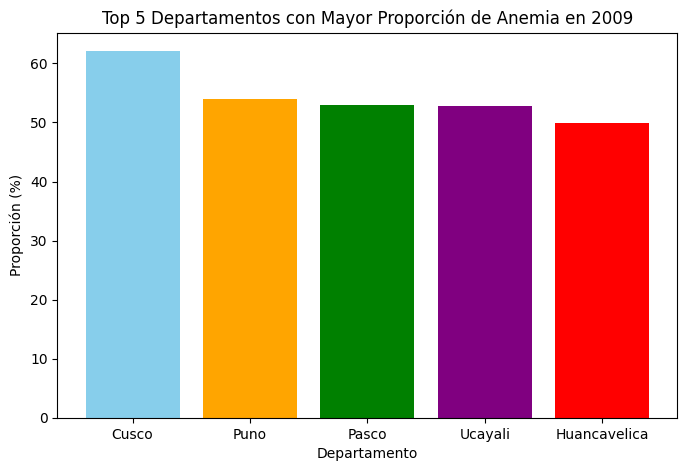


Interpretación detallada para el año 2009:
Cusco tiene la proporción más alta de anemia total en 2009, alcanzando un valor de aproximadamente 62.10%. Esto lo posiciona como el departamento más afectado por la anemia en ese año.
Los otros 4 departamentos (Puno, Pasco, Ucayali y Huancavelica) presentan proporciones relativamente similares, alrededor del rango de 49.90% y 53.90%.


In [118]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para capitalizar correctamente los nombres de los departamentos
def capitalize_departments(department):
    return department.title()

def grafico_top_5(anio):
    # Comparación en el año 2023 mostrando solo los 5 departamentos con mayor proporción
    top_5 = df.nlargest(5, anio)
    top_5['Departamento'] = top_5['Departamento'].apply(capitalize_departments)
    plt.figure(figsize=(8, 5))
    plt.bar(top_5['Departamento'], top_5[anio], color=['skyblue', 'orange', 'green', 'purple', 'red'])
    plt.title(f'Top 5 Departamentos con Mayor Proporción de Anemia en {anio}')
    plt.xlabel('Departamento')
    plt.ylabel('Proporción (%)')
    plt.show()

    # Ejemplo de interpretación detallada
    max_depto = top_5.iloc[0]
    otros_departamentos = top_5.iloc[1:5]
    segundo_depto = top_5.iloc[1]
    quinto_depto = top_5.iloc[4]
    print(f"\nInterpretación detallada para el año {anio}:")
    print(f"{max_depto['Departamento']} tiene la proporción más alta de anemia total en {anio}, alcanzando un valor de aproximadamente {max_depto[anio]:.2f}%. Esto lo posiciona como el departamento más afectado por la anemia en ese año.")
    print(f"Los otros 4 departamentos ({', '.join(top_5['Departamento'][1:4])} y {top_5['Departamento'].iloc[4]}) presentan proporciones relativamente similares, alrededor del rango de {quinto_depto[anio]:.2f}% y {segundo_depto[anio]:.2f}%.")
grafico_top_5(anio_seleccionado)

# Análisis Temporal de los casos de Anemia por departamento desde 2008

In [14]:
df.to_csv("anemia_data.csv", index=False)

In [15]:
import pandas as pd

df = pd.read_csv("anemia_data.csv")

Gráfico guardado como: Tendencia_Anemia_Lima_2008_2023.png


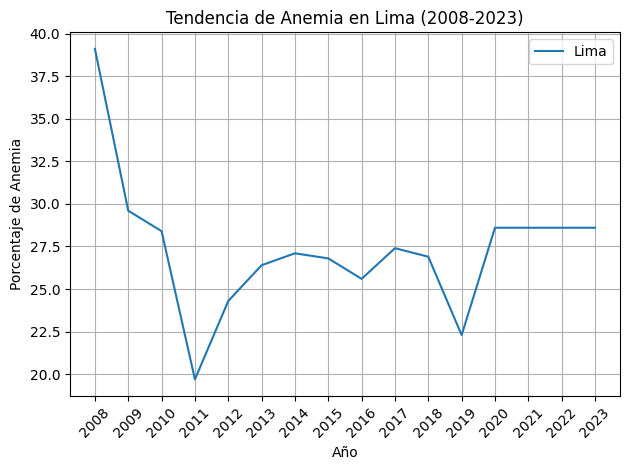


Interpretación de los datos para el departamento Lima:
Desde el año 2008 hasta el año 2023, se ha observado una tendencia en los porcentajes de anemia en el departamento de Lima.
El valor máximo de anemia fue 39.10% en el año 2008 y el valor mínimo fue 19.70% en el año 2011.


In [81]:
# Función para graficar el departamento seleccionado
def analisis_temporal(departamento):
    dept_data = df_total[lista_dptos == departamento]
    valid_years = [year for year in anios_disponibles if year != '2000']
    plt.plot(valid_years, dept_data[valid_years].values[0], label=departamento)
    plt.title(f'Tendencia de Anemia en {departamento} (2008-2023)')
    plt.xlabel('Año')
    plt.ylabel('Porcentaje de Anemia')
    plt.grid(True)
    plt.legend()

    # Ajustar la rotación y el tamaño de las etiquetas del eje x
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()  # Asegurar que los elementos no se corten
        
    # Guardar el gráfico como archivo PNG
    output_filename = f"Tendencia_Anemia_{departamento}_2008_2023.png"
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"Gráfico guardado como: {output_filename}")

    # Mostrar gráfico
    plt.show()

    # Interpretación de los datos
    print(f"\nInterpretación de los datos para el departamento {departamento_seleccionado}:")
    print(f"Desde el año 2008 hasta el año 2023, se ha observado una tendencia en los porcentajes de anemia en el departamento de {departamento_seleccionado}.")
        
    max_anemia = dept_data[valid_years].values[0].max()
    min_anemia = dept_data[valid_years].values[0].min()
        
    # Encontrar los años correspondientes a los valores máximo y mínimo
    year_max = valid_years[dept_data[valid_years].values[0].argmax()]
    year_min = valid_years[dept_data[valid_years].values[0].argmin()]
        
    print(f"El valor máximo de anemia fue {max_anemia:.2f}% en el año {year_max} y el valor mínimo fue {min_anemia:.2f}% en el año {year_min}.")
    
# Generar el primer gráfico
analisis_temporal(departamento_seleccionado)